In [13]:
# open the data set tn.movie_budgets.csv.gz
import pandas as pd

df_budget = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
df_budget.head() 
df_budget.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [14]:
# check for missing values
df_budget.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [25]:
# clean and convert monetary values to float
# identify monetary columns
monetary_columns = ["production_budget", "domestic_gross", "worldwide_gross"]
# clean the monetary_columns
for col in monetary_columns:
    df_budget[col] = df_budget[col].replace('[$,]', '', regex=True).astype(float)
print(df_budget.dtypes)

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object


#### Q2. What budget ranges for movies are the most profitable - to avoid spending too much, and increase ROI

In [26]:
# check for correlation between the production budget and worldwide gross

correlation = df_budget['production_budget'].corr(df_budget['worldwide_gross'])
correlation

np.float64(0.7483059765694753)

##### The correlation coefficient of 0.75 indicates that there is a strong positive linear relationship between the production budget and the worldwide gross which means that the higher the production budget is, the higher the worldwide gross sales will be.

#### Finding what the optimal budget for the production of a movie is to maximize on the Return on investment

In [23]:
# import libraries
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
from sklearn.linear_model import LinearRegression

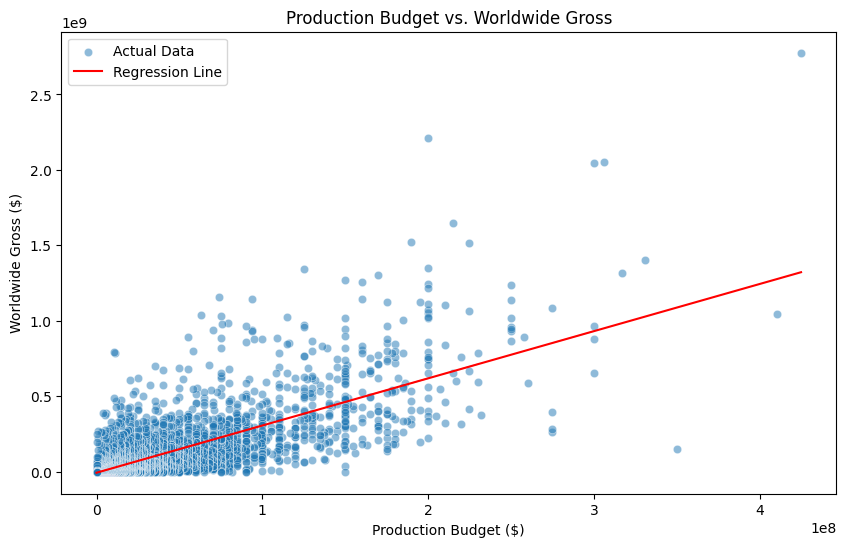

In [30]:
X = df_budget['production_budget'].values.reshape(-1, 1) # independent variable
y = df_budget['worldwide_gross'].values.reshape(-1, 1) #dependent variable

# linear regression model
model = LinearRegression()
model.fit(X, y)

df_budget['predicted_gross'] = model.predict(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_budget["production_budget"], y=df_budget["worldwide_gross"], alpha=0.5, label="Actual Data")
sns.lineplot(x=df_budget["production_budget"], y=df_budget["predicted_gross"], color="red", label="Regression Line")
plt.xlabel("Production Budget ($)")
plt.ylabel("Worldwide Gross ($)")
plt.title("Production Budget vs. Worldwide Gross")
plt.legend()
plt.show()

In [32]:
optimal_budget = df_budget.loc[df_budget["predicted_gross"].idxmax(), "production_budget"]
optimal_budget

np.float64(425000000.0)